In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
ratings = pd.read_csv("clean_Ratings")

In [79]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 894068 entries, 0 to 894067
Data columns (total 4 columns):
Unnamed: 0    894068 non-null int64
user_id       894068 non-null int64
book_id       894068 non-null int64
rating        894068 non-null int64
dtypes: int64(4)
memory usage: 27.3 MB


In [22]:
# Picking Random 1500 users and 3000 books from the books more rated and users who are avid readers. See code below ->
#Avid Readers

import random
userBookRateCount = ratings.groupby('user_id').count()['book_id'].sort_values(ascending = False)
refineduserBookCount = userBookRateCount[userBookRateCount > 8]
finaluserlist = random.sample(refineduserBookCount.index.to_list(), 1500)



In [39]:
bookRateCount = ratings.groupby('book_id').count()['user_id'].sort_values(ascending = False)
refinedBookCount = bookRateCount[bookRateCount >=87]
finalbooklist = random.sample(refinedBookCount.index.to_list(), 3000)



In [47]:
#Creating user index from user id
userindex = pd.DataFrame(data = finaluserlist)
#Creating book index from book id
bookindex = pd.DataFrame(data = finalbooklist)

In [115]:
n_users = len(finaluserlist)
n_items = len(finalbooklist)
ratings = ratings[ratings['user_id'].apply(lambda x: x in finaluserlist)]


,Unnamed: 0,user_id,book_id,rating
6,6,5885,1,5
17,17,11927,1,4
40,40,24389,1,4
61,61,32923,1,5
65,65,33872,1,5
...,...,...,...,...
893949,893949,22494,9999,4
893983,893983,45918,9999,5
894046,894046,37122,10000,5
894053,894053,43068,10000,3


In [117]:
final_ratings = ratings[ratings['book_id'].apply(lambda x: x in finalbooklist)]
final_ratings

,Unnamed: 0,user_id,book_id,rating
1271,1271,7001,14,3
1283,1283,11927,14,3
1284,1284,11945,14,4
1301,1301,21676,14,5
1312,1312,27499,14,2
...,...,...,...,...
893523,893523,14763,9994,2
893524,893524,15788,9994,5
893583,893583,49281,9994,4
893634,893634,13043,9995,3


In [118]:
#Train Test Split
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(final_ratings, test_size=0.25)

In [119]:
#Create two user-item matrices, one for training and another for testing
train_data_matrix = np.zeros((n_users, n_items))
for index, line in train_data.iterrows():
    train_data_matrix[userindex.index[userindex[0] == line.user_id], bookindex.index[bookindex[0] == line.book_id]] = line.rating  

test_data_matrix = np.zeros((n_users, n_items))
for index, line in test_data.iterrows():
    test_data_matrix[userindex.index[userindex[0] == line.user_id], bookindex.index[bookindex[0] == line.book_id]] = line.rating

In [136]:
sparsity = float(len(test_data_matrix.nonzero()[0]))
sparsity /= (test_data_matrix.shape[0] * test_data_matrix.shape[1])
sparsity *= 100


(1500, 3000)

The sparsity of data is 0.27% which is not enough for doing collaborative filtering. The results might not be very accurate. Hence we need to explore more recommendation techniques later. But the good thing is that the sparsity of original data was 0.26%. So we were able to improve the sparsity by selectively choosing certain types of users and books.

In [121]:
def similarity(ratings, kind='user', epsilon=1e-9):
    # epsilon -> small number for handling dived-by-zero errors
    if kind == 'user':
        sim = ratings.dot(ratings.T) + epsilon
    elif kind == 'item':
        sim = ratings.T.dot(ratings) + epsilon
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return (sim / norms / norms.T)

In [122]:
def predict(ratings, similarity, kind='user'):
    if kind == 'user':
        return similarity.dot(ratings) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif kind == 'item':
        return ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])

In [123]:
from sklearn.metrics import mean_squared_error

def get_mse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

In [124]:
user_similarity = similarity(train_data_matrix, kind='user')
item_similarity = similarity(train_data_matrix, kind='item')
item_prediction = predict(train_data_matrix, item_similarity, kind='item')
user_prediction = predict(train_data_matrix, user_similarity, kind='user')

print ('User-based CF MSE: ' + str(get_mse(user_prediction, test_data_matrix)))
print ('Item-based CF MSE: ' + str(get_mse(item_prediction, test_data_matrix)))

User-based CF MSE: 14.724828539506461
Item-based CF MSE: 14.541211168487681


Here we see that Item based filtering works marginally better that user based. But the overall performance is not that good. We need to find better ways to bring mse under 10.

In [125]:
#Using top K similar users to calculate the weighted predictions
def predict_topk(ratings, similarity, kind='user', k=40):
    pred = np.zeros(ratings.shape)
    if kind == 'user':
        for i in range(ratings.shape[0]):
            top_k_users = [np.argsort(similarity[:,i])[:-k-1:-1]]
            for j in range(ratings.shape[1]):
                pred[i, j] = similarity[i, :][top_k_users].dot(ratings[:, j][top_k_users]) 
                pred[i, j] /= np.sum(np.abs(similarity[i, :][top_k_users]))
    if kind == 'item':
        for j in range(ratings.shape[1]):
            top_k_items = [np.argsort(similarity[:,j])[:-k-1:-1]]
            for i in range(ratings.shape[0]):
                pred[i, j] = similarity[j, :][top_k_items].dot(ratings[i, :][top_k_items].T) 
                pred[i, j] /= np.sum(np.abs(similarity[j, :][top_k_items]))        
    
    return pred

In [126]:
pred = predict_topk(train_data_matrix, user_similarity, kind='user', k=40)
print ('Top-k User-based CF MSE: ' + str(get_mse(pred, test_data_matrix)))

pred = predict_topk(train_data_matrix, item_similarity, kind='item', k=40)
print ('Top-k Item-based CF MSE: ' + str(get_mse(pred, test_data_matrix)))

C:\Users\sablo\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  
C:\Users\sablo\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if __name__ == '__main__':


Top-k User-based CF MSE: 14.690556012403688


C:\Users\sablo\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  
C:\Users\sablo\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  from ipykernel import kernelapp as app


Top-k Item-based CF MSE: 14.513372535091367


Top K users approach gave a marginal decrease in mse which is not enough to call it a close. We will now iterate over various values of K to find best mse.

In [107]:
k_array = [5, 15, 30, 50, 100, 200]
user_train_mse = []
user_test_mse = []
item_test_mse = []
item_train_mse = []


for k in k_array:
    user_pred = predict_topk(train_data_matrix, user_similarity, kind='user', k=k)
    item_pred = predict_topk(train_data_matrix, item_similarity, kind='item', k=k)
    
    user_train_mse += [get_mse(user_pred, train_data_matrix)]
    user_test_mse += [get_mse(user_pred, test_data_matrix)]
    
    item_train_mse += [get_mse(item_pred, train_data_matrix)]
    item_test_mse += [get_mse(item_pred, test_data_matrix)]  

C:\Users\sablo\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  
C:\Users\sablo\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if __name__ == '__main__':
C:\Users\sablo\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which w

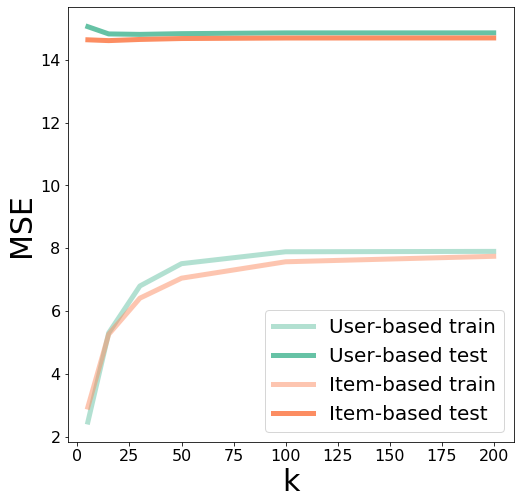

In [109]:
%matplotlib inline
pal = sns.color_palette("Set2", 2)

plt.figure(figsize=(8, 8))
plt.plot(k_array, user_train_mse, c=pal[0], label='User-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, user_test_mse, c=pal[0], label='User-based test', linewidth=5)
plt.plot(k_array, item_train_mse, c=pal[1], label='Item-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, item_test_mse, c=pal[1], label='Item-based test', linewidth=5)
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('k', fontsize=30);
plt.ylabel('MSE', fontsize=30);

There is not significant change by changing K value

In [134]:
def predict_nobias(ratings, similarity, kind='user'):
    if kind == 'user':
        user_bias = ratings.mean(axis=1)
        ratings = (ratings - user_bias[:, np.newaxis]).copy()
        pred = similarity.dot(ratings) / np.array([np.abs(similarity).sum(axis=1)]).T
        pred += user_bias[:, np.newaxis]
    elif kind == 'item':
        item_bias = ratings.mean(axis=0)
        ratings = (ratings - item_bias[np.newaxis, :]).copy()
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
        pred += item_bias[np.newaxis, :]
        
    return pred

user_pred = predict_nobias(train_data_matrix, user_similarity, kind='user')
print ('Bias-subtracted User-based CF MSE: ' + str(get_mse(user_pred, test_data_matrix)))

item_pred = predict_nobias(train_data_matrix, item_similarity, kind='item')
print ('Bias-subtracted Item-based CF MSE: ' + str(get_mse(item_pred, test_data_matrix)))

Bias-subtracted User-based CF MSE: 14.695787055328962
Bias-subtracted Item-based CF MSE: 14.549099791858715


The bias substracted method does not give any improvement in results.

In [138]:
final_ratings.to_csv("final_model_ratings")